Consider the following query:

```sql
SELECT * FROM t WHERE x = 3 ORDER BY y
```

Where we have two indexes on `t`, one on `x` (`X`) and one on `y` (`Y`).
Assume both are covering.

We can service this query in two ways:
* Scan `X` (which allows us to quickly find rows having `x = 3`), restricted to `x = 3`, then sort the result
* Scan `Y` (which gives us the result ordered on `y`), filtering out rows not having `x = 3`.

We will consider two parameters that dictate the behaviour of these two alternatives:
* $s$ (for _selectivity_), the proportion of rows in `t` matching the condition, and
* $c$ (for _cardinality_), the total number of rows in the table.

We need to pick some cost-unit constants, whose actual values are not particularly important:
* $q_1$ is the cost of scanning a single row.
* $q_2$ is the constant factor on the cost of a sort (i.e., times $n\log n$).
* $q_3$ is the cost of emitting a row from a filter.

We can then cost these two like so:
* The cost of scanning `X` then sorting: $C_X(s,c) = q_1sc + q_2sc\log(sc)$
* The cost of scanning `Y` then filtering: $C_Y(s,c) = q_1c + q_3sc$

The values of the $q$s are up for some amount of debate, but I will use a novel strategy: I will pick ones that illustrate my point.

In [1]:
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.colors import Colormap

%matplotlib inline  

In [2]:
def scan_cost(num_rows):
    return num_rows

def sort_cost(num_rows):
    return num_rows * np.log(num_rows+1)

def cost_scan_x(sel, card):
    num_rows = sel * card
    return scan_cost(num_rows) + sort_cost(num_rows)

def cost_scan_y(sel, card):
    return scan_cost(card) + 0.5 * card * sel

In [3]:
plt.style.use('seaborn')

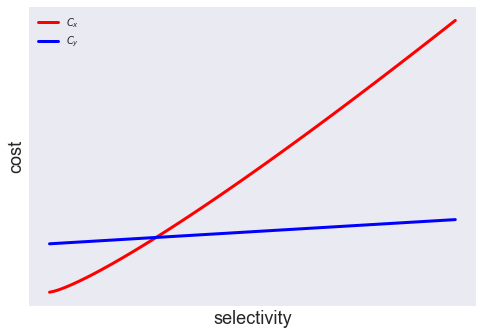

In [4]:
x = np.linspace(0.0, 1.0, 100)
plt.plot(x, cost_scan_x(x, 100), c="red", linewidth=3)
plt.plot(x, cost_scan_y(x, 100), c="blue", linewidth=3)
plt.xlabel("selectivity", fontsize=18)
plt.ylabel("cost", fontsize=18)
plt.xticks([])
plt.yticks([])
plt.legend(["$C_x$", "$C_y$"])
plt.show()

This gives us a good idea of the behaviour of our two cost models! However, we've fixed a constant table size, and this chart doesn't tell us anything about the behaviour as our table size changes. We can do another plot fixing the selectivity and then varying the table size.

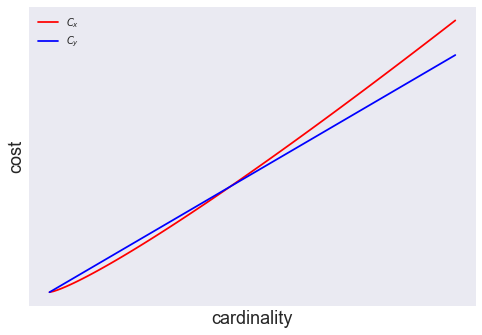

In [5]:
card = np.linspace(0.0, 1000, 100)
sel = 0.2
plt.plot(card, cost_scan_x(sel, card), c="red")
plt.plot(card, cost_scan_y(sel, card), c="blue")
plt.xlabel("cardinality", fontsize=18)
plt.ylabel("cost", fontsize=18)
plt.xticks([])
plt.yticks([])
plt.legend(["$C_x$", "$C_y$"])
plt.show()

Both these plots help us understand the behaviour of our implementations at a fixed cardinality or selectivity, but what we'd really like is a more complete picture of how the cost models behave. We could plot them in 3D space, but I don't really understand how to use matplotlib very well, so we'll have to find another way. What's noteworthy however, is that we actually don't need the full fidelty of a 3D plot. The only relevant thing for our query planner is whether it chooses the red line or the blue line. We only care about whether at any given point, the red or the blue line gives us a cheaper cost. We might be interested in understanding the behaviour beyond that, but our query planner can slap a big ol' "WHO CARES" on every other piece of information this graph contains. So what if we only plot that?

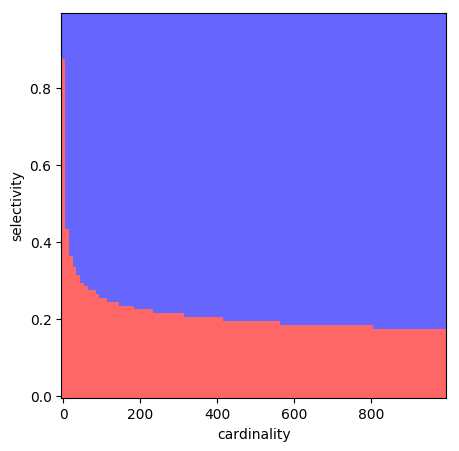

In [6]:
size = 100
maxcard = 1000
maxsel = 1
numticksx = 5
x = np.linspace(1, maxcard+1, size)
y = np.linspace(0, maxsel, size)

X, Y = np.meshgrid(x, y)
def plan(sel, card):
    x_cost = cost_scan_x(sel, card)
    y_cost = cost_scan_y(sel, card)
    if x_cost < y_cost:
        return (1.0,0.4,0.4)
    else:
        return (0.4,0.4,1.0)

plt.style.use('default')
z = np.array([plan(j,i) for j in y for i in x])
Z = z.reshape(size, size, 3)
plt.figure(figsize=(5,5))
plt.xlabel('cardinality')
plt.ylabel('selectivity')
plt.xticks(range(0, size, int(size/numticksx)), map(lambda x: int(x/size*maxcard), range(0, size, int(size/numticksx))))
plt.yticks(range(0, size, int(size/numticksx)), map(lambda x: x/size*maxsel, range(0, size, int(size/numticksx))))
plt.imshow(Z, origin="lower")
plt.show()

In [16]:
from generate import get_plan, get_cost, CARDS, Q21, Q2
from random import random

m = plt.get_cmap('hsv')

def plot_diagram(**kwargs):
    seen = {}
    count = 0
    def getplan(p1, p2):
        nonlocal count
        plan = get_plan(kwargs.get('sql'), p1, p2, database=kwargs.get('database', 'rydb'))
        if not plan in seen:
            seen[plan] = m((count * 0.1337) % 1)
            count += 1
        return seen[plan]
    size = kwargs.get('size', 10)
    numticksx = 10
    numticksy = 10
    zoom = kwargs.get('zoom', 1)

    xrange = kwargs.get('xrange', (0, 100))
    yrange = kwargs.get('yrange', (0, 100))
    maxval = 100000
    x = np.linspace(xrange[0], xrange[1]/zoom, size)
    y = np.linspace(yrange[0], yrange[1]/zoom, size)

    X, Y = np.meshgrid(x, y)

    z = np.array([getplan(i,j) for j in y for i in x])
    
    Z = z.reshape(size, size, 4)
    plt.figure(figsize=(7,7))
    plt.xlabel(kwargs.get("xlabel", ""))
    plt.ylabel(kwargs.get("ylabel", ""))
    
    if kwargs.get("normalize_ticks", False):
        xs = map(lambda x: round(x/10/zoom, 2), range(0, 10))
        ys = map(lambda x: round(x/10/zoom, 2), range(0, 10))
    else:
        xs = map(
            lambda x: round(x/size/zoom*(xrange[1]-xrange[0])+xrange[0], 2),
            range(0, size, int(size/numticksx)),
        )
        ys = map(
            lambda x: round(x/size/zoom*(yrange[1]-yrange[0])+yrange[0], 2),
            range(0, size, int(size/numticksy)),
        )
    plt.xticks(
        range(
            0,
            size,
            int(size/numticksx),
        ),
        xs,
    )
    plt.yticks(
        range(
            0,
            size,
            int(size/numticksy),
        ),
        ys,
    )
    print(seen)
    plt.imshow(Z, origin="lower")
    plt.show()
    
def plot_costs(**kwargs):
    seen = {}
    count = 0
    def getplan(p1, p2):
        nonlocal count
        cost_range = get_cost(kwargs.get('sql'), p1, p2, database=kwargs.get('database', 'rydb'))
        return sum(cost_range)/2
    size = kwargs.get('size', 10)
    numticksx = 10
    numticksy = 10
    zoom = kwargs.get('zoom', 1)

    xrange = kwargs.get('xrange', (0, 100))
    yrange = kwargs.get('yrange', (0, 100))
    maxval = 100000
    x = np.linspace(xrange[0], xrange[1]/zoom, size)
    y = np.linspace(yrange[0], yrange[1]/zoom, size)

    X, Y = np.meshgrid(x, y)

    z = np.array([getplan(i,j) for j in y for i in x])
    
    Z = z.reshape(size, size)
    plt.figure(figsize=(7,7))
    plt.xlabel(kwargs.get("xlabel", ""))
    plt.ylabel(kwargs.get("ylabel", ""))
    
    if kwargs.get("normalize_ticks", False):
        xs = map(lambda x: round(x/10/zoom, 2), range(0, 10))
        ys = map(lambda x: round(x/10/zoom, 2), range(0, 10))
    else:
        xs = map(
            lambda x: round(x/size/zoom*(xrange[1]-xrange[0])+xrange[0], 2),
            range(0, size, int(size/numticksx)),
        )
        ys = map(
            lambda x: round(x/size/zoom*(yrange[1]-yrange[0])+yrange[0], 2),
            range(0, size, int(size/numticksy)),
        )
    plt.xticks(
        range(
            0,
            size,
            int(size/numticksx),
        ),
        xs,
    )
    plt.yticks(
        range(
            0,
            size,
            int(size/numticksy),
        ),
        ys,
    )
    plt.pcolor(Z)
    plt.show()

def plot_tpch(q, t1, t2):
    plot_diagram(
        sql=q.parameterize(t1, t2),
        size=100,
        xlabel=t1,
        ylabel=t2,
        xrange=(0, CARDS[t1]),
        yrange=(0, CARDS[t2]),
        normalize_ticks=True,
        database="tpch",
    )
#     plot_costs(
#         sql=q.parameterize(t1, t2),
#         size=100,
#         xlabel=t1,
#         ylabel=t2,
#         xrange=(0, CARDS[t1]),
#         yrange=(0, CARDS[t2]),
#         normalize_ticks=True,
#         database="tpch",
#     )

def plot_tpch_all(q):
    for i in range(0, len(q.tables)):
        for j in range(i+1, len(q.tables)):
            plot_tpch(q, q.tables[i], q.tables[j])

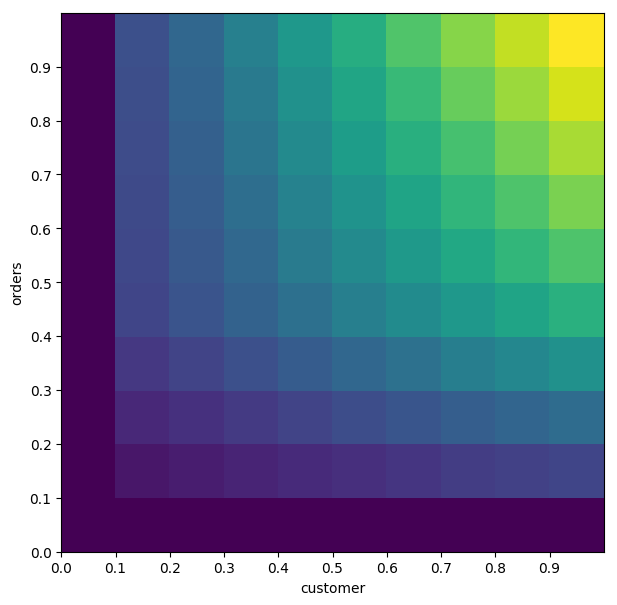

In [15]:
plot_costs(
    sql=s,
    size=10,
    xlabel="customer",
    ylabel="orders",
    xrange=(0, 150000),
    yrange=(0, 6000000),
    normalize_ticks=True,
    database="tpch",
)

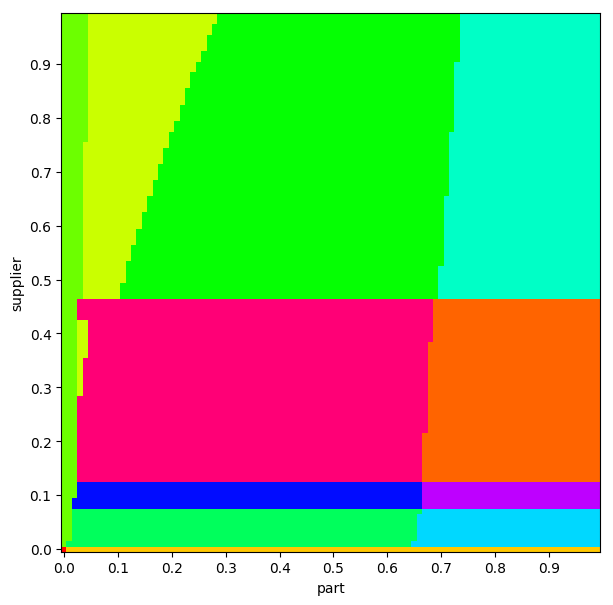

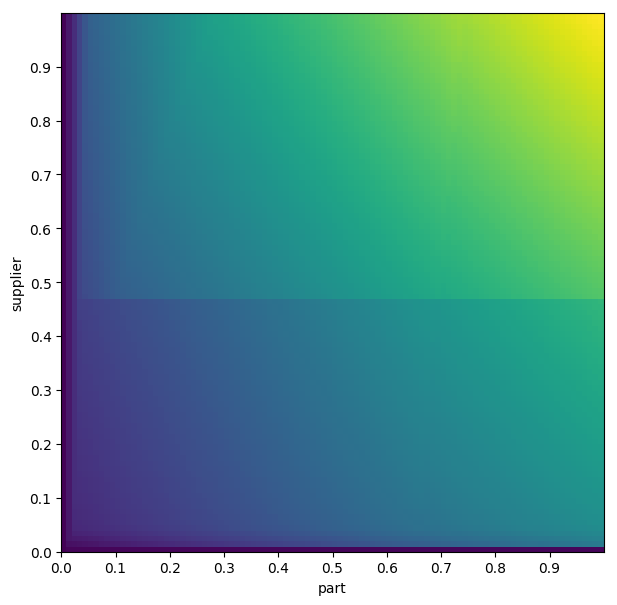

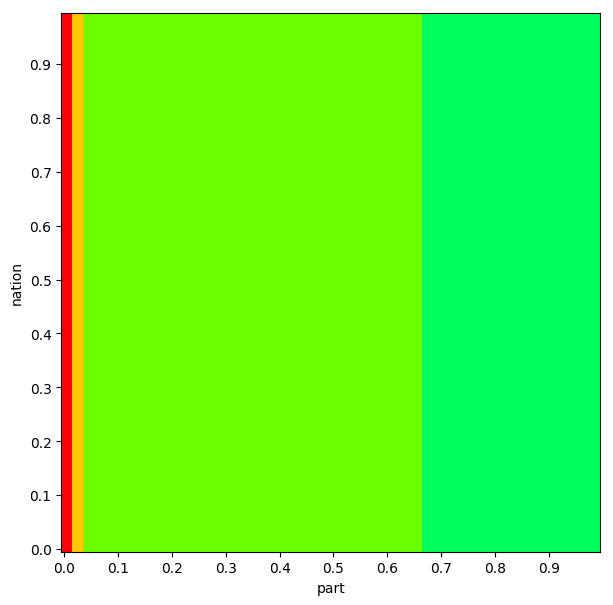

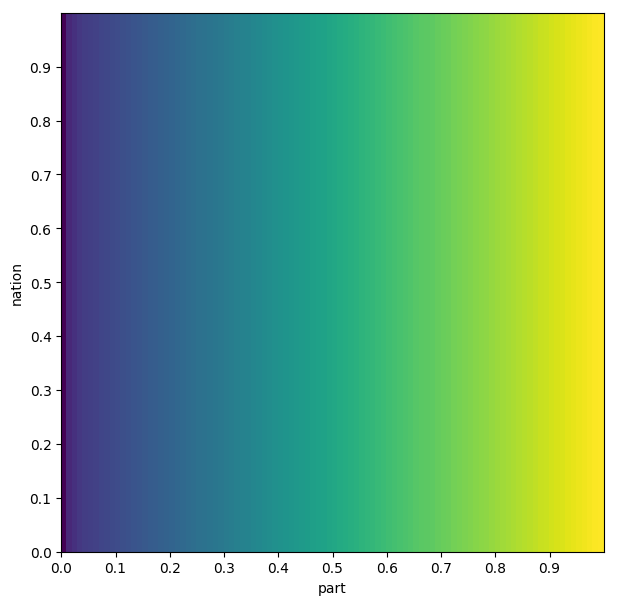

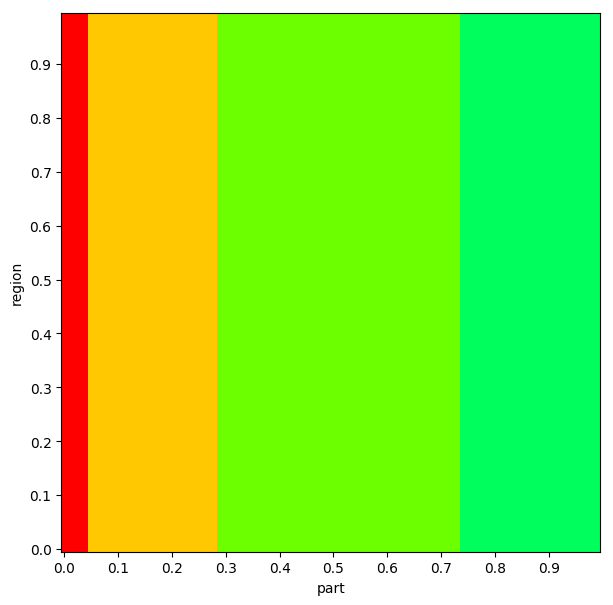

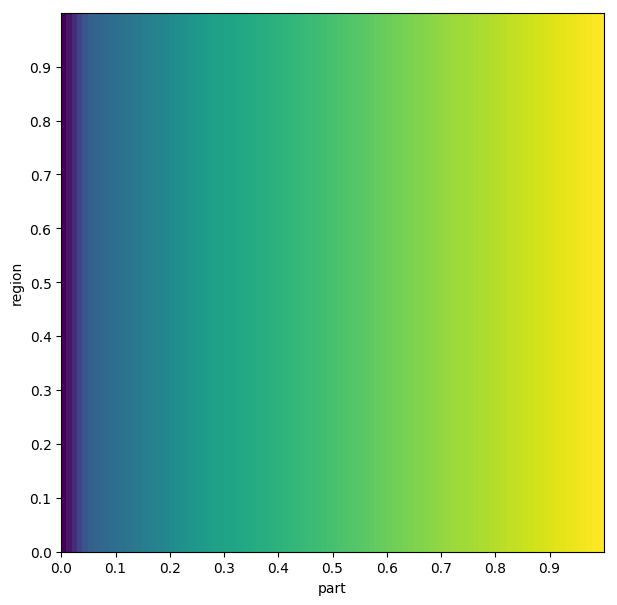

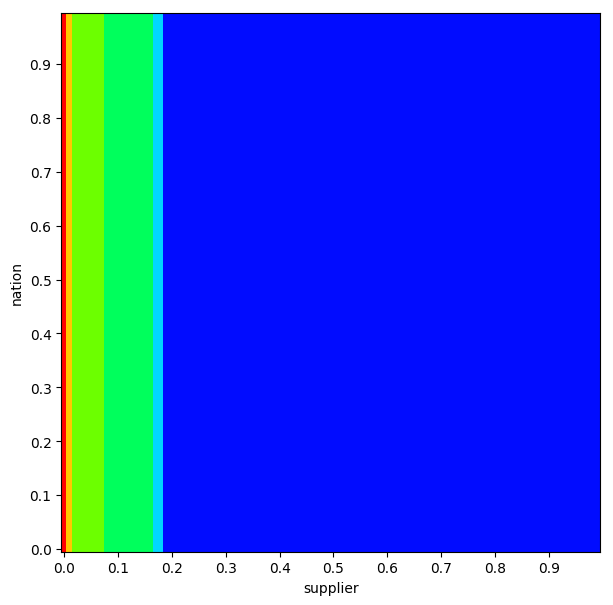

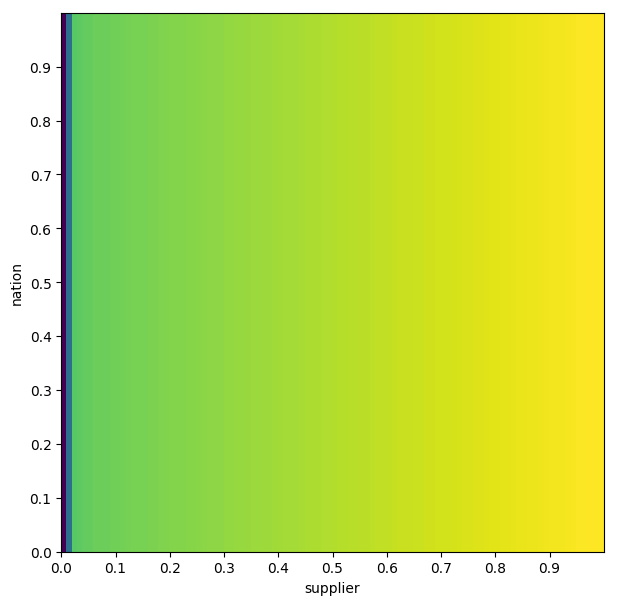

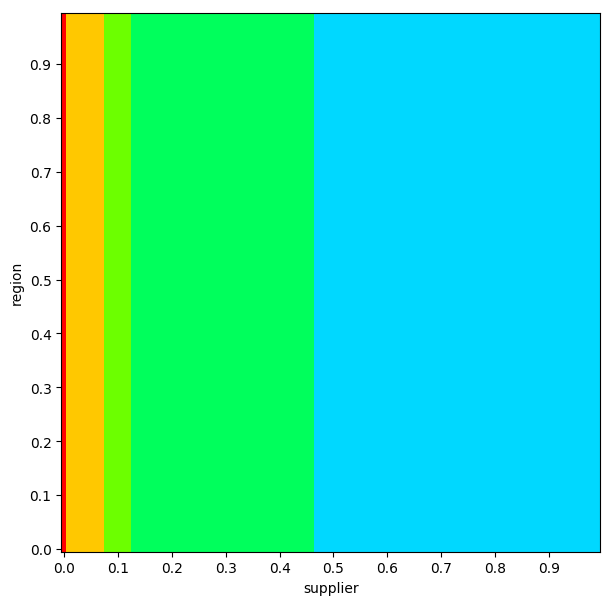

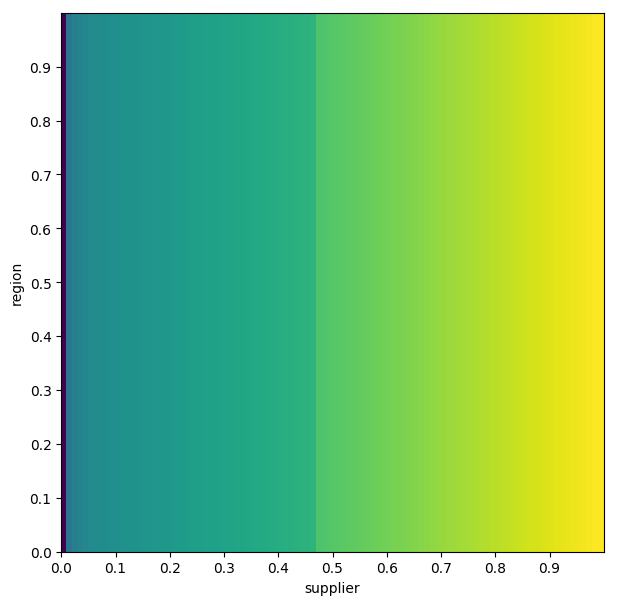

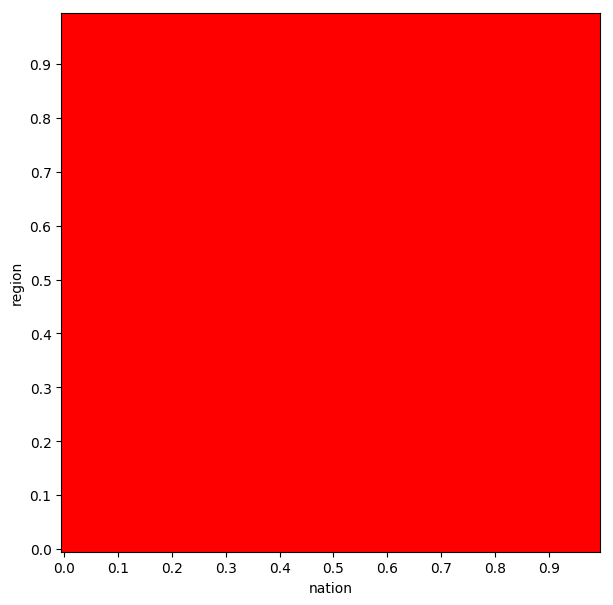

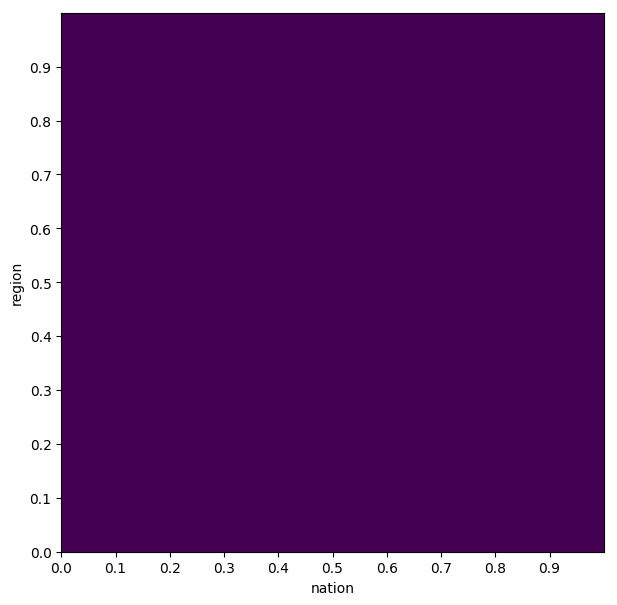

In [21]:
plot_tpch_all(Q2)

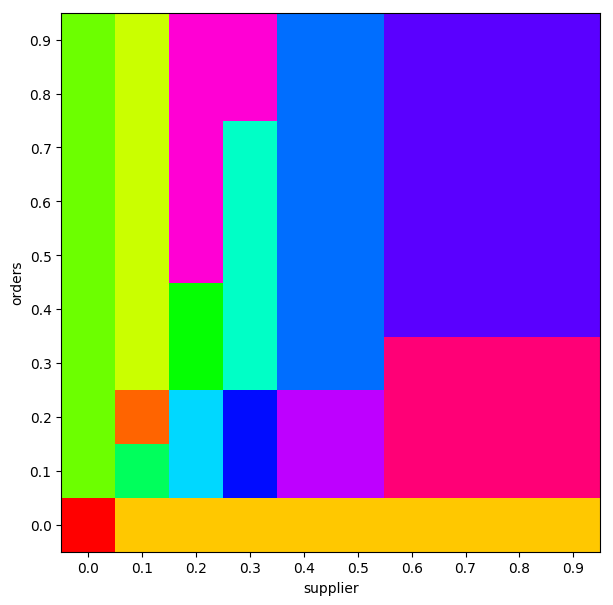

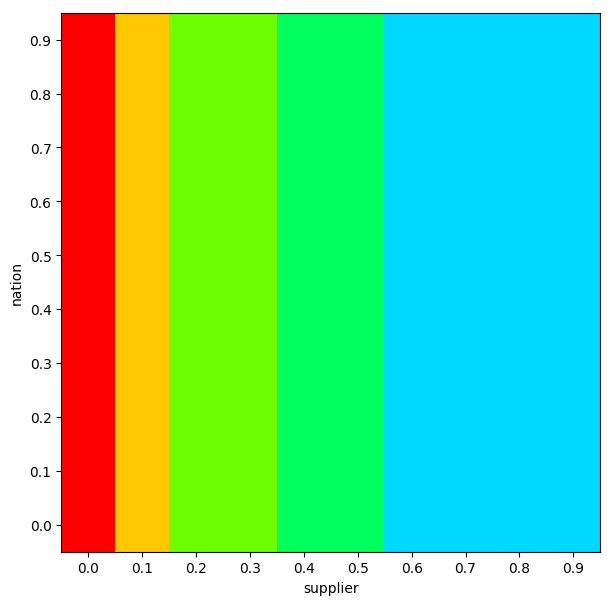

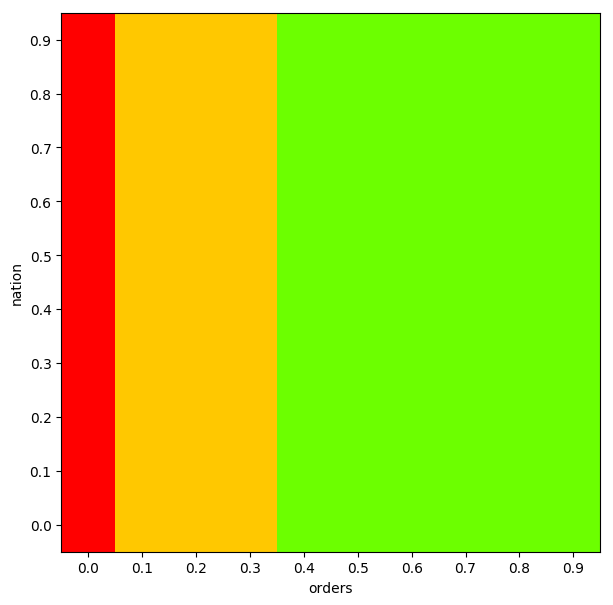

In [12]:
plot_tpch_all(Q21)

{'Limit  \n  ->  Sort  \n        Sort Key:  DESC, supplier.s_name\n        ->  GroupAggregate  \n              Group Key: supplier.s_name\n              ->  Sort  \n                    Sort Key: supplier.s_name\n                    ->  Nested Loop Anti Join  \n                          ->  Nested Loop Semi Join  \n                                Join Filter: \n                                ->  Nested Loop  \n                                      Join Filter: \n                                      ->  Nested Loop  \n                                            ->  Nested Loop  \n                                                  ->  Index Scan using orders_o_orderkey_idx on orders  \n                                                        Index Cond: \n                                                        Filter: \n                                                  ->  Index Scan using lineitem_l_orderkey_idx on lineitem l1  \n                                                        In

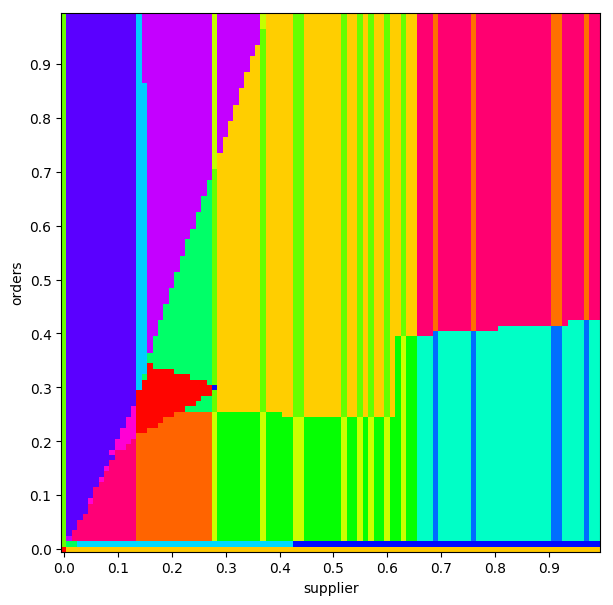

In [17]:
plot_tpch(Q21, "supplier", "orders")

In [10]:
s = """
EXPLAIN SELECT mc.note AS production_note,
       t.title AS movie_title,
       t.production_year AS movie_year
FROM company_type AS ct,
     info_type AS it,
     movie_companies AS mc,
     movie_info_idx AS mi_idx,
     title AS t
WHERE ct.kind = 'production companies'
  AND it.info = 'top 250 rank'
  AND mc.note NOT LIKE '%%(as Metro-Goldwyn-Mayer Pictures)%%'
  AND (mc.note LIKE '%%(co-production)%%'
       OR mc.note LIKE '%%(presents)%%')
  AND ct.id = mc.company_type_id
  AND t.id = mc.movie_id
  AND t.id = mi_idx.movie_id
  AND mc.movie_id = mi_idx.movie_id
  AND it.id = mi_idx.info_type_id
  AND t.production_year < %d
  AND mi_idx.movie_id < %d;
"""
# plot_diagram(
#     sql=s,
#     size=100,
#     xlabel="movie year",
#     ylabel="movie id",
#     xrange=(1950, 2050),
#     yrange=(0, 100000),
# )

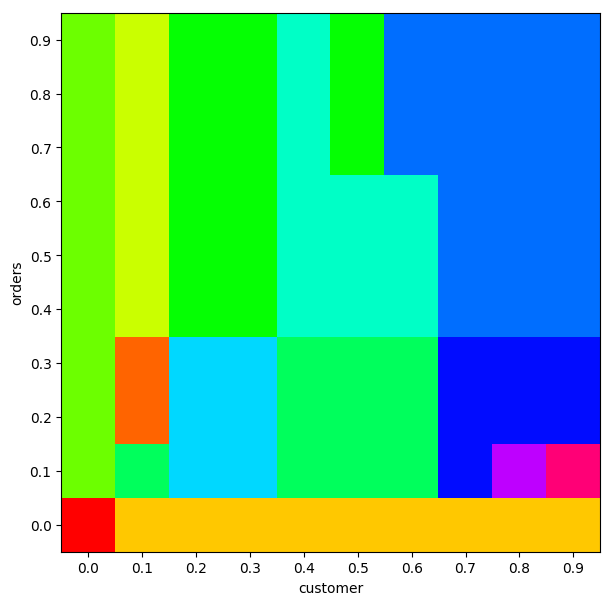

In [17]:
s = """
explain select
	c_custkey,
	c_name,
	sum(l_extendedprice * (1 - l_discount)) as revenue,
	c_acctbal,
	n_name,
	c_address,
	c_phone,
	c_comment
from
	customer,
	orders,
	lineitem,
	nation
where
	c_custkey = o_custkey
	and l_orderkey = o_orderkey
	and o_orderdate >= date '1993-10-01'
	and o_orderdate < date '1993-10-01' + interval '3' month
	and l_returnflag = 'R'
	and c_nationkey = n_nationkey
    and c_custkey < %d
    and o_orderkey < %d
group by
	c_custkey,
	c_name,
	c_acctbal,
	c_phone,
	n_name,
	c_address,
	c_comment
order by
	revenue desc;
"""
pairs = [
    ["customer", "c_custkey", 150000],
    ["orders", "o_orderkey", 6000000],
    ["supplier", "s_suppkey", 10000],
    
]
plot_diagram(
    sql=s,
    size=10,
    xlabel="customer",
    ylabel="orders",
    xrange=(0, 150000),
    yrange=(0, 6000000),
    normalize_ticks=True,
    database="tpch",
)

In [ ]:
s = """
explain select
	c_name,
	c_custkey,
	o_orderkey,
	o_orderdate,
	o_totalprice,
	sum(l_quantity)
from
	customer,
	orders,
	lineitem
where
	o_orderkey in (
		select
			l_orderkey
		from
			lineitem
		group by
			l_orderkey having
				sum(l_quantity) > 300
	)
	and c_custkey = o_custkey
	and o_orderkey = l_orderkey
    and c_custkey < %d
    and o_orderkey < %d
group by
	c_name,
	c_custkey,
	o_orderkey,
	o_orderdate,
	o_totalprice
order by
	o_totalprice desc,
	o_orderdate;

"""
plot_diagram(
    sql=s,
    size=100,
    xlabel="customer",
    ylabel="order",
    xrange=(0, 150000),
    yrange=(0, 6000000),
    normalize_ticks=True,
    database="tpch",
)

In [ ]:
plot_diagram(
    sql=Q21.parameterize("supplier", "orders"),
    size=100,
    xlabel="supplier",
    ylabel="orders",
    xrange=(0, 10000),
    yrange=(0, 150000),
    normalize_ticks=True,
    database="tpch",
)